In [1]:
###IMPORT
import numpy as np
import pandas as pd
import dataprocessing
from stochasticmodel import StochasticLoadModel, StochasticSimulationResult
import loaddata
import matplotlib.pyplot as plt
import seaborn as sns

%reload_ext autoreload
%autoreload 2

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": '16'
})

In [2]:
stationen=loaddata.load_stations()
display(stationen)

,Name,Hausanschluesse,Leistung,Cluster,Kurzname,Zaehler,LeistungproHA,LeistungproZaehler,ZaehlerproHA
0,Durchholz,73,400,W4,A,99,5.479452,4.040404,1.356164
1,Guennemannshof,62,400,W1,B,72,6.451613,5.555556,1.161290
2,Kaemperfeld,24,630,W3,C,40,26.250000,15.750000,1.666667
3,Lutherplatz,53,630,S,D,394,11.886792,1.598985,7.433962
4,Marienhospital alt,43,630,S,E,382,14.651163,1.649215,8.883721
5,Querweg,26,400,W2,F,50,15.384615,8.000000,1.923077
6,Rehnocken 1,19,200,W2,G,34,10.526316,5.882353,1.789474
7,Rudolf-Koenig-Strasse,40,630,S,H,315,15.750000,2.000000,7.875000
8,Schule Durchholz,53,400,W1,I,90,7.547170,4.444444,1.698113


In [3]:
list_power_d, list_power_yd, list_power_ysd, list_power_ymd, list_mat_power_d, list_power_ywd, list_power_yswd, list_power_only_d = loaddata.load_data_from_measurements([0,1,2,3,4,5,6,7,8], d=True, yd=True, ysd=True,ywd=True,yswd=True)

Lade Daten von Station  Durchholz
Lade Daten von Station  Guennemannshof
Lade Daten von Station  Kaemperfeld
Lade Daten von Station  Lutherplatz
Lade Daten von Station  Marienhospital alt
Lade Daten von Station  Querweg
Lade Daten von Station  Rehnocken 1
Lade Daten von Station  Rudolf-Koenig-Strasse
Lade Daten von Station  Schule Durchholz


In [53]:
MAPES=np.zeros([9,3])
all_sim=list()
all_ref=list()
all_res=list()
all_mape=list()

for station in range(0,9):
    station_no = station
    power_d = list_power_d[station_no]
    power_yd = list_power_yd[station_no]
    power_ysd = list_power_ysd[station_no]
    power_ywd = list_power_ywd[station_no]
    power_yswd = list_power_yswd[station_no]
    data_input = [power_yswd[2018], power_yd[2018],power_yswd[2018]]
    reference = power_yd[2018]     #list_power_only_d[1].iloc[:,177:542]
    mymodel=StochasticLoadModel(normalization=[4,1,1,2],order_regression=6)                 #[4,0,1,2]
    mymodel.parameterize(data_in=data_input,plots=False)
    res = mymodel.simulate(n_runs=1)
    energy_reference = 0.25*reference.sum().sum()
    denormalized_result=mymodel.denormalize(res,new_case_4=4,energy=energy_reference,max_value=reference.max().max())
    A, B, C, D = denormalized_result.analyze(reference,plots=False,show_tables=False, export_plots=False)
    MAPES[station,:]=A
    all_res.insert(len(all_res),denormalized_result)
    all_ref.insert(len(all_ref),B)
    all_sim.insert(len(all_sim),C)
    all_mape.insert(len(all_mape),D)

>>> Parmetrisiere ein stochastisches Modell...
Normiere Daten gemaess: Normierung: 4 , Lokal/Global: 1 , Grenzen: 1 , Reskalierung: 2
>>> Berechne alle Uebergangsmatrizen...
>>> Berechne Uebergangsmatrix...
>>> Berechne Uebergangsmatrix...
>>> Berechne Uebergangsmatrix...
>>> Berechne Uebergangsmatrix...
>>> Berechne Uebergangsmatrix...
>>> Berechne Uebergangsmatrix...
>>> Berechne Uebergangsmatrix...
>>> Berechne Uebergangsmatrix...
>>> Berechne Uebergangsmatrix...
>>> Berechnung der Uebergangsmatrizen abgeschlossen!
>>> Parametrisierung abgeschlossen!
>>> SIMULATION GESTARTET...
>>> Starte Markov-Ketten-Simulation - Iteration 0
Tag 0
Starte Random-Walk an Tag 2  in Jahreszeit 0  mit Voergaenger-Leistung [0.]
Vorgaenger-Leistung nicht zulaessig! Neuer Vorgaenger-Zustand: 0
Tag 1
Starte Random-Walk an Tag 0  in Jahreszeit 0  mit Voergaenger-Leistung [0.6120489981462907]
Tag 2
Starte Random-Walk an Tag 0  in Jahreszeit 0  mit Voergaenger-Leistung [0.8104401652700356]
Tag 3
Starte Random

In [54]:
df=pd.DataFrame()
for i in [0,1,3,4,5,6,7,8]:
    df[str(i)]=all_mape[i]

<AxesSubplot:>

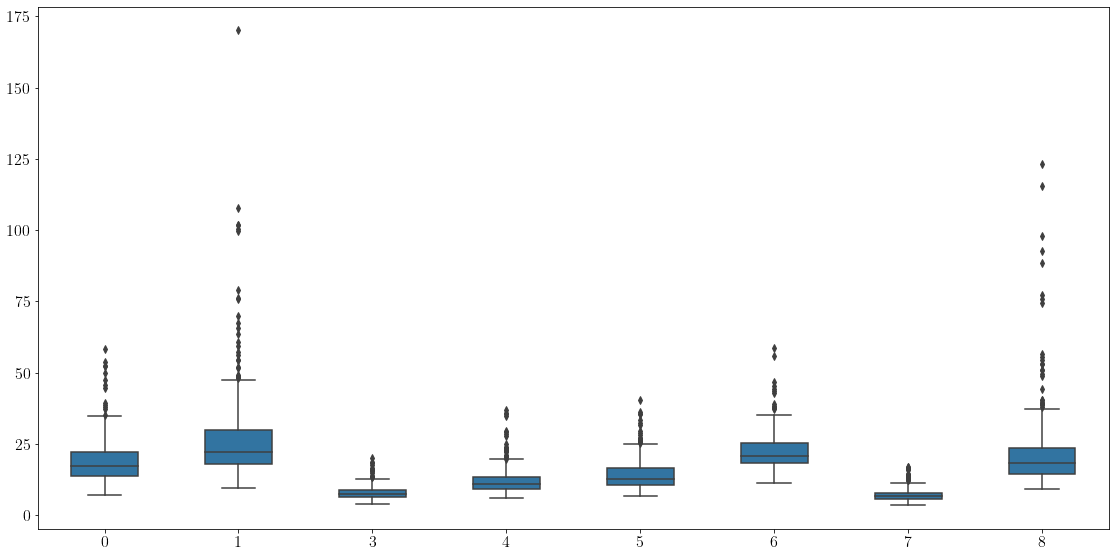

In [55]:
plt.figure(figsize=(19.2,9.6))
sns.boxplot(data=df,width=0.5,color='tab:blue')

In [56]:
mi=pd.MultiIndex.from_product([np.arange(0,9,1), ['Simulation','Messdaten']])

In [60]:
max_vec_s=np.zeros([365,9])
max_vec_m=np.zeros([365,9])
for i in range(0,9):
    max_vec_s[:,i]=np.min(np.reshape(all_sim[i],[365,96],order='F'),axis=1)
    max_vec_m[:,i]=np.min(np.reshape(all_ref[i],[365,96],order='F'),axis=1)

In [61]:
times=np.arange(0,365,1)
allmax=pd.DataFrame(index=times,columns=mi)
for station in range(0,9):
    allmax[station,'Simulation']=max_vec_s[:,station]
    allmax[station,'Messdaten']=max_vec_m[:,station]
allmaxlong=allmax.stack(level=[0,1]).reset_index(level=0, drop=True).reset_index()

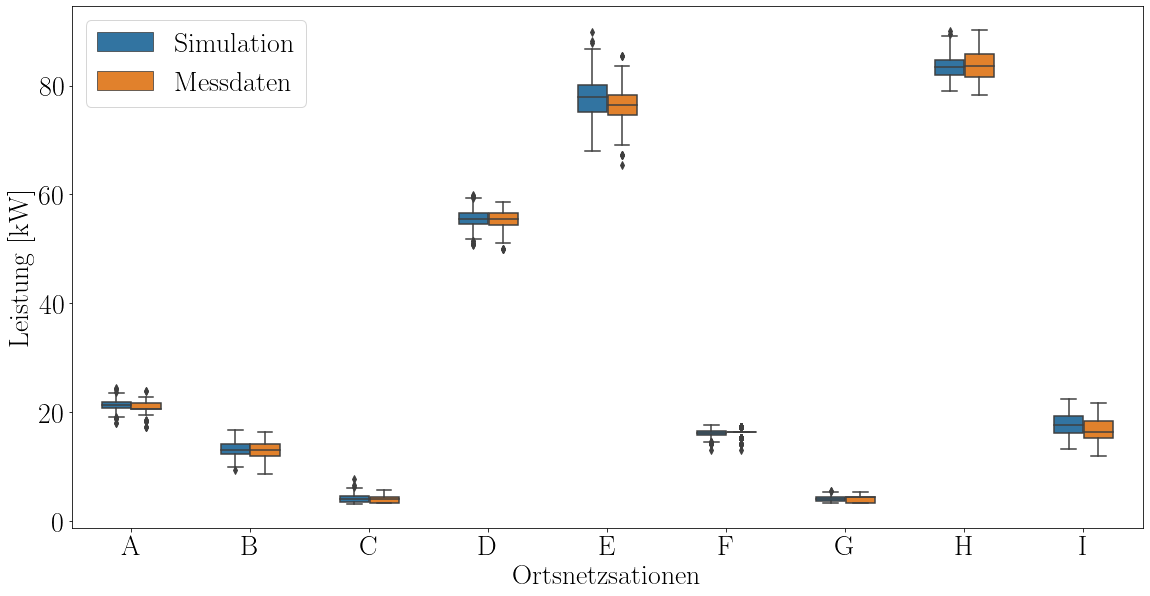

In [64]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": '28'
})
#plt.figure(figsize=(19.2,9.6))
this_fig, this_ax=plt.subplots(figsize=(19.2,9.6))
sns.boxplot(x='level_0',y=0, data=allmaxlong, hue="level_1",width=0.5,hue_order=['Simulation','Messdaten'])
plt.xlabel('Ortsnetzsationen')
plt.ylabel('Leistung [kW]')
plt.xticks(np.arange(0,9,1),['A','B','C','D','E','F','G','H','I'])

handles, labels = this_ax.get_legend_handles_labels()
plt.legend(handles=handles[0:], labels=labels[0:])
plt.savefig('export/Boxplot_Alle_Minimalwerte.pdf',bbox_inches='tight')

In [ ]:
times=np.arange(0,35040,1)

In [ ]:
alldata=pd.DataFrame(index=times,columns=mi)
allmax=pd.DataFrame()

In [ ]:
for station in range(0,9):
    alldata[station,'Simulation']=all_sim[station]
    alldata[station,'Messdaten']=all_ref[station]

In [ ]:
alllong=alldata.stack(level=[0,1]).reset_index(level=0, drop=True).reset_index()

In [ ]:

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": '28'
})
#plt.figure(figsize=(19.2,9.6))
this_fig, this_ax=plt.subplots(figsize=(19.2,9.6))
sns.boxplot(x='level_0',y=0, data=alllong, hue="level_1",width=0.5,hue_order=['Simulation','Messdaten'])
plt.xlabel('Ortsnetzsationen')
plt.ylabel('Leistung [kW]')
plt.xticks(np.arange(0,9,1),['A','B','C','D','E','F','G','H','I'])

handles, labels = this_ax.get_legend_handles_labels()
plt.legend(handles=handles[0:], labels=labels[0:])
plt.savefig('Boxplot_Spektrum.pdf',bbox_inches='tight')

In [ ]:
station_no = 3
power_d = list_power_d[station_no]
power_yd = list_power_yd[station_no]
power_ysd = list_power_ysd[station_no]
power_ywd = list_power_ywd[station_no]
power_yswd = list_power_yswd[station_no]
data_input = [power_yswd[2018], power_yd[2018],power_yswd[2018]]
reference = power_yd[2018]     #list_power_only_d[1].iloc[:,177:542]

In [ ]:
gruppe=[3,4,7]
gesamt_df=list()
for i in gruppe:
    df=list_power_yswd[i][2018]
    normed=df/df.max().max()
    gesamt_df.insert(len(gesamt_df),normed)

new_df=gesamt_df[0]
for j in range(1,len(gesamt_df)):
    new_df=pd.concat([new_df,gesamt_df[j]],axis=1,levels=['Jahreszeit'])

new_df1=new_df.copy()

gruppe=[4,7]
gesamt_df=list()
df3=list_power_yd[3][2018]/list_power_yd[3][2018].max().max()
df4=list_power_yd[4][2018]/list_power_yd[4][2018].max().max()
df7=list_power_yd[7][2018]/list_power_yd[7][2018].max().max()
df=df3+df4+df7
df=df/3

data_input=[new_df1,df,new_df1]

Parametrisierung

In [ ]:
mymodel=StochasticLoadModel(normalization=[4,1,1,2],order_regression=6)                 #[4,0,1,2]
mymodel.parameterize(data_in=data_input,plots=False)

In [ ]:
res = mymodel.simulate(n_runs=1)

In [ ]:
energy_reference = 0.25*reference.sum().sum()
denormalized_result=mymodel.denormalize(res,new_case_4=4,energy=energy_reference,max_value=reference.max().max())
A, B, C = denormalized_result.analyze(reference,show_tables=False, export_plots=False,filename_plots='unbekannt_gruppe')

In [ ]:
station_no = 7
power_d = list_power_d[station_no]
power_yd = list_power_yd[station_no]
power_ysd = list_power_ysd[station_no]
power_ywd = list_power_ywd[station_no]
power_yswd = list_power_yswd[station_no]
data_input = [power_yswd[2018], power_yd[2018],power_yswd[2018]]
reference = power_yd[2018]     #list_power_only_d[1].iloc[:,177:542]
energy_reference = 0.25*reference.sum().sum()
denormalized_result=mymodel.denormalize(res,new_case_4=4,energy=energy_reference,max_value=reference.max().max())
A, B, C = denormalized_result.analyze(reference,show_tables=False, export_plots=False,filename_plots='unbekannt_gruppe')

In [ ]:
maxwert=power_ysd[2018].max().max()
typedays_1 = power_ysd[2018]/maxwert
typedays_2={}
for season in range(0,3):
    for weekday in range(0,3):
        typedays_2[season,weekday]=typedays_1.loc[:,season].loc[:,weekday].mean(axis=1).to_numpy()

In [ ]:
mymodel.checkconvergence(typedays_2,n_it=50)

Denormalisierung

Gruppen

In [ ]:
"""
gruppe=[3,4,7]
gesamt_df=list()
for i in gruppe:
    df=list_power_yswd[i][2018]
    normed=df/df.max().max()
    gesamt_df.insert(len(gesamt_df),normed)

new_df=gesamt_df[0]
for j in range(1,len(gesamt_df)):
    new_df=pd.concat([new_df,gesamt_df[j]],axis=1,levels=['Jahreszeit'])

new_df1=new_df.copy()

gruppe=[4,7]
gesamt_df=list()
df3=list_power_yd[3][2018]/list_power_yd[3][2018].max().max()
df4=list_power_yd[4][2018]/list_power_yd[4][2018].max().max()
df7=list_power_yd[7][2018]/list_power_yd[7][2018].max().max()
df=df3+df4+df7
df=df/3

data_input=[new_df1,df,new_df1]
"""

Fragmente

In [ ]:
pquer=mw[1]
pvor=mw[0]
pnach=mw[2]
pdelta=pnach-pvor
d=55

A=[[d**2, d],[(2*d+1)*(d+1)/6, (d+1)/2]]
invA=np.linalg.inv(A)
RHS=[[pnach-pvor],[pquer-pvor]]
coeff=np.dot(invA,RHS)
a=coeff[0]
b=coeff[1]
c=pvor

mypoly=np.poly1d([a,b,c])
X=np.linspace(0,55,56)
Y=mypoly(X)
plt.plot(X,Y)
Z=Y/pquer
plt.plot(X,Z)

In [ ]:
pquer=mw[1]
pvor=mw[2]
pnach=mw[0]
pdelta=pnach-pvor
d=47

A=[[d**2, d],[(2*d+1)*(d+1)/6, (d+1)/2]]
invA=np.linalg.inv(A)
RHS=[[pnach-pvor],[pquer-pvor]]
coeff=np.dot(invA,RHS)
a=coeff[0]
b=coeff[1]
c=pvor

mypoly=np.poly1d([a,b,c])
X=np.linspace(0,55,56)
Y=mypoly(X)
plt.plot(X,Y)

In [ ]:
"""
E_0=np.zeros(9)
E_1=np.zeros(9)
E_2=np.zeros(9)
E_mean=np.zeros(9)
for i in range(0,9):
    E_0[i]=0.25*list_power_ywd[i][2018].loc[:,0].sum(axis=0).mean()
    E_1[i]=0.25*list_power_ywd[i][2018].loc[:,1].sum(axis=0).mean()
    E_2[i]=0.25*list_power_ywd[i][2018].loc[:,2].sum(axis=0).mean()
    E_mean[i]=0.25*list_power_ywd[i][2018].sum(axis=0).mean()

factors_0=np.ones(9)
factors_1=np.ones(9)
factors_2=np.ones(9)
for i in range(0,9):
    factors_0[i]=E_0[i]/E_mean[i]
    factors_1[i]=E_1[i]/E_mean[i]
    factors_2[i]=E_2[i]/E_mean[i]

plt.figure()
plt.scatter([7,3,8,0,1,5,6,2,4],E_0)
plt.scatter([7,3,8,0,1,5,6,2,4],E_1)
plt.scatter([7,3,8,0,1,5,6,2,4],E_2)
plt.xticks(np.linspace(0,8,9),['D','E','H','B','I','F','G','A','C'])
plt.figure()
plt.scatter([7,3,8,0,1,5,6,2,4],factors_0)
plt.scatter([7,3,8,0,1,5,6,2,4],factors_1)
plt.scatter([7,3,8,0,1,5,6,2,4],factors_2)
plt.xticks(np.linspace(0,8,9),['D','E','H','B','I','F','G','A','C'])
"""